<a href="https://colab.research.google.com/github/lmhrva/ml-housing-project/blob/master/Ch_2_ML_HOUSING_Scratch_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is my scratch notebook for my ML_HOUSING project.

In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

In [2]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# **Get Data**

I'm going to connect to the data for this project in Aurelien Geron's github. I will not add the ability to save the files because this isn't my local computer.

In [3]:
import os
import tarfile
import urllib.request #2017: from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/" #2017: "...handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Skipping ahead to the histograms:

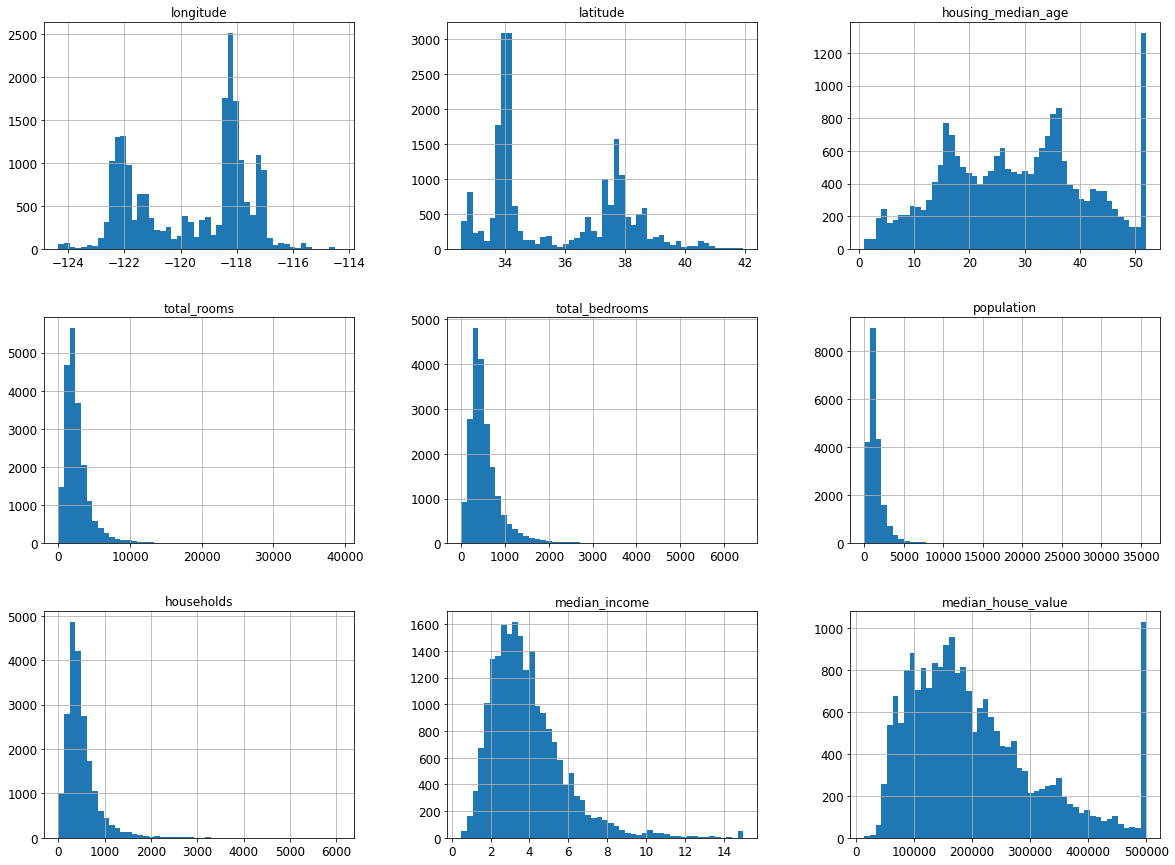

In [8]:
# We could plot each attribute at a time, but to save time let's call the hist() method on the whole dataset
# %matplotlib inline works in Jupyter notebooks and Google Colab, telling Matplotlib to use the notebook's graphical backend to draw on your screen
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

# note: can't comment within a line! have to put comments on separate lines

Notes:  
* Median Income seems not to be in currency. It is also capped at 15 on the high end and 0.5 on the low end.
* Housing median age is also capped at 50.
* Median housing value is also capped at 500,000; this could be an issue if we the client needs accurate predictions even beyond 500,000. If they do I can either get accurate labels for instances beyond 500,000 OR take all the incidents beyond the cap out of the training and test set (I guess that makes it possible to train the model without teaching it that houses stick to 500,000 in a clump like that? idk).
* These attributes have very different scales.
* Many of these histograms are tail-heavy; we'll have to transform some later to make it more bell-shaped.

# **Create a Test Set**
To avoid *data snooping*, which is when you look at test data and accidentally detect patterns that might bias you toward an over-fitted model, choose the test data at this stage and don't look at it again until it's needed.

There are several options to getting the test set:

1. Pick 20% of the instances at random using `numpy.random.permutation()` to shuffle the set, then splitting out 0.2 (20%) into a separate index to get two random indices: training data (16512 instances) and test data (4128 instances)

This only works once for a single set. We need to be able to run this process multiple times (unclear why, need to read further). If you run it again, you'll get a different set of test data, which will eventually cycle through the whole dataset. We don't want to do that because you'll make a model that fits too close to thise dataset and won't be ready for new data.

2. Make the 20% selected above into a "permanent" test set: either save it from the first run and load it in subsequent runs, or set the random number generator's seed before calling `numpy.random.permutation()` so it always generates the same shuffled indices.

I'm not sure how either of these options work realistically. Hopefully I'll understand them better as we go. In general though, setting aside a permanent set from this first run will only work until we fetch an updated dataset.

3. Use a unique, immutable identifier for each instance to separate out the 20%: Import hashlib. Compute a hash from the ID and run a function to set aside instances with the last byte of their hash being less than or equal to 51 because 51 is 20% of 256.

This method works because an updated dataset would have updated IDs. No new test set would contain any instances from a previous training set because that previous set would meet that hash parameter. However, the dataset does not have unique identifiers. We have to make some.


## Method 1 and 2: Split Data Using numpy.random.permutation

[Geron's updated walkthrough](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) shows the code needed to split up our dataset into test and training sets.

The first splits the test using Method #2 above: Make the selected set "permanent" by setting the random number generator's seed (`np.random.seed`) before calling `numpy.random.permutation()` so it always generates the same shuffled indices. This is done by defining the function `split_train_test`.

***Note***: *This method is for illustration only, tying back to the book. Sklearn uses another method called `train_test_split()`.*

In [9]:
# to make this notebook's output identical at every run
np.random.seed(42)
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(housing, 0.2)

In [10]:
len(train_set)

16512

In [11]:
len(test_set)

4128

## Method 3: Split Data Using Random Sampling on Unique IDs

Method #3 uses unique, consistent IDs. This means it won't break when we fetch an updated dataset.

Geron's walkthrough uses the following to define the `test_set_check` function to define hash ids in the data. This solution does not seem to support any hash functions, but is compatible with Python 2 and 3:

```
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
```

The one my book gives supports any hash function but runs slower and does not support Python 2:

```
import hashlib

def test_set_check(identifier, test_ratio, hash):  
  return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio
```

This is the updated version, which supports any hash and is compatible with Python 2 and 3:

In [12]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

***Side Bar: Hash Tables are Cool***

>I dove down a Wiki rabbit hole on cryptographic hash functions that I fully intend to revisit because they are super cool.
>   
>This article by Vaidehi Joshi links to a [podcast episode](https://www.codenewbie.org/basecs/28) that introduced me to hash tables: [Taking Hash Tables Off the Shelf](https://medium.com/basecs/taking-hash-tables-off-the-shelf-139cbf4752f0). It describes hash tables as an alternative to linked lists, arrays, and stacks, because in order to search through those you need to look at each instance in them to find the one you're looking for. This means searching for something in them ends up being in *linear time*, or O(n). Using a hash function to place or interact with a value/instance in the array/table allows us to work in *constant time*, or O(1). There is nothing to look at before or after the value itself because of the hash function.
>
>This sounds so much like cryptography. I've heard of security experts needing to know about "hashing". I think this is the connection. My data tables hold information in specific spots you can find if you know the hash function that placed them there. When you create a code, you use equations to transform a value into its symbolic equal in some way, or at least map out how to find it - that's encoding, cryptography, encryption. That sounds very much like what we're doing here on a smaller scale: Hash tables help me find what I'm looking for. They can also be used to hide information so that only I can find it.
>
>Here's the [wiki article](https://en.wikipedia.org/wiki/SHA-2) on SHA-2 hashes. Designed by the NSA in 2001, released royalty-free: "The SHA-2 family consists of six hash functions with digests (hash values) that are 224, 256, 384 or 512 bits: SHA-224, SHA-256, SHA-384, SHA-512, SHA-512/224, SHA-512/256". The SHA-3 family of hashes were released in 2015 in addition to SHA-2, not to replace them.
>
>I will *definitely* want to look more into this later.

Now I define the function `split_train_test_by_id`, which will use IDs from the data's ID column and apply whichever `test_set_check` method I chose to determine what is in the test set.

In [13]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

***Note***: *This [site](https://stackabuse.com/lambda-functions-in-python/) was pretty descriptive in how to use lambda functions in Python, so I'll read up on that later.*

My dataset does not have an ID column! I need to give it one. For example, I could use this code to add an "index" column to use as the ID:
```
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
```
That would work, but only if new data is appended to the end of the dataset and no row ever gets deleted. That's a lot of *ifs*. In my experience, the data load part of the process often gets shifted to someone else, which means those errors are very likely to occur.

Instead, I'll create IDs using the more stable features of latitude and longitude values for each district:

In [14]:
housing_with_id = housing.reset_index() # adds an `index` column
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [15]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [16]:
# I'm curious about this test set vs the one I create using train_test_split

test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4373 entries, 8 to 20636
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               4373 non-null   int64  
 1   longitude           4373 non-null   float64
 2   latitude            4373 non-null   float64
 3   housing_median_age  4373 non-null   float64
 4   total_rooms         4373 non-null   float64
 5   total_bedrooms      4325 non-null   float64
 6   population          4373 non-null   float64
 7   households          4373 non-null   float64
 8   median_income       4373 non-null   float64
 9   median_house_value  4373 non-null   float64
 10  ocean_proximity     4373 non-null   object 
 11  id                  4373 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 444.1+ KB


In [17]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [18]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


In [19]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 20046 to 3665
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           4128 non-null   float64
 1   latitude            4128 non-null   float64
 2   housing_median_age  4128 non-null   float64
 3   total_rooms         4128 non-null   float64
 4   total_bedrooms      3921 non-null   float64
 5   population          4128 non-null   float64
 6   households          4128 non-null   float64
 7   median_income       4128 non-null   float64
 8   median_house_value  4128 non-null   float64
 9   ocean_proximity     4128 non-null   object 
dtypes: float64(9), object(1)
memory usage: 354.8+ KB


I'm not sure what I did at the end there. test_set before train_test_split seems very similar to after, with just a couple hundred less instances. Mine matches the example from Geron's Github though so I'll keep going and see where it takes me.

## Split Data Using Stratified Sampling

***Stratified Sampling***: the population is divided into homogeneous subgroups called *strata*, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

This is a good thing to do, especially if we are working with a small population. In our case, since we are using the median income to predict median housing prices, we can make sure the test set is representative of the different categories of median income in the population. These categories (buckets) do not exist yet, however. The median income is a continuous (discrete?) numerical attribute. So we'll create them ourselves.

First let's look at the histogram of the median attribute more closely.

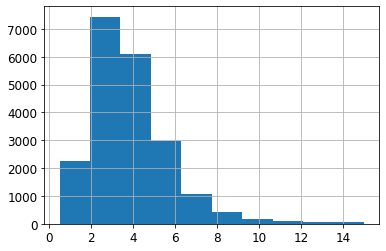

In [20]:
housing["median_income"].hist()

***Note:*** *Why does this one look so different from the one when I called .hist() above? It's not capped at 1500 and shows the value in currency form while the other one doesn't, I thought.*

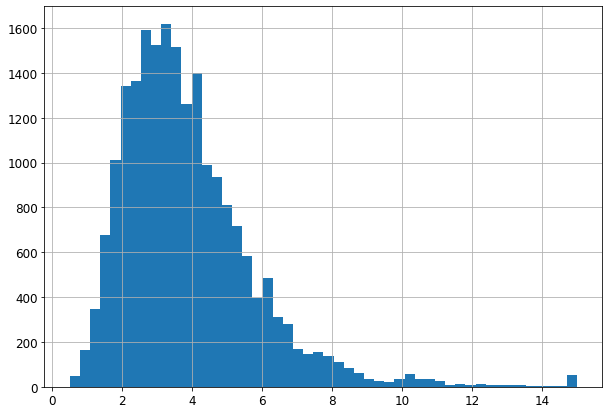

In [21]:
housing["median_income"].hist(bins=50, figsize=(10,7))

***Why tho.*** *Is it because I specified bins at 50? That just means each group of 50 gets a bar at their mean height, right? So why... This is going to take more googling than I have time for right now, let's move on.*

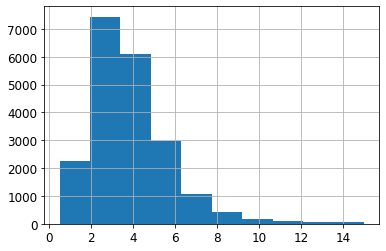

In [22]:
housing["median_income"].hist()

Looks like this distributes the data according to default bins. You can see most median incomes cluster around $20k-$50k, but some go far beyond $60k. I need to have a sufficient number of instances in my dataset for each stratum so the tratum's importance is not biased. This means I should not have too many strata, and each stratum shold be large enough.

Next, the 2017 book shows this code to create an income category attribute by dividing the median income by 1.5 (to limit the number of income categories) and rounding up using `cell` (to have discrete categories), then merging all the categories greater than 5 into category 5:

```
housing["income_cat"] = np.cell(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
```

Here is how Geron's Github does it:

In [23]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [24]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

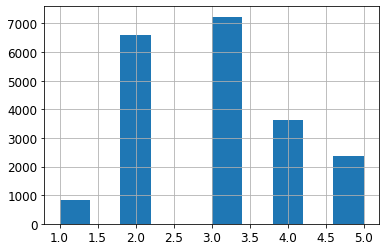

In [25]:
housing["income_cat"].hist()

Now I can do stratified smapling based on the income category. The book and Geron's Github both use Scikit-Learn's `StratifiedShuffleSplit` class to do this:

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [27]:
# Look at income category proportions in the test set:

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

***Note***: *Numbers 5 and 1 are slightly different than Geron's numbers, both from the book and the Github:*
```
5:   0.114583  
1:   0.039729
```
*It looks like there are slightly more stratum in category 5 and less in category 1 than in Geron's example. Because they do not match, the %error is off for those two values in the Stratified column of the table below.*

In [28]:
# Look at the proportions in the overall dataset:

housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [29]:
# Compare income category proporions in the overall dataset with the test set 
# using stratified sampling and the test set using random sampling:

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [30]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


*The table above does not match the example because the proportions for 1 and 5 are off in the Stratified test set. Could it be just a random shuffle? #1 has a standard error of 0.4, which seems high... But if the point is that they are much more clustered around 0 than the % error of the Random test set, that point is made. The Stratified test set is more representative of the Overall dataset than the Random one.*

*I can't spend more time on this, I have to keep moving.*

Next I'd remove the `income_cat` attribute so the data is back to its original state.

# Explore the Data

First we'll create a copy of the `housing` training set so we don't harm the actual training set:

In [31]:
housing = strat_train_set.copy()

Scatterplot:

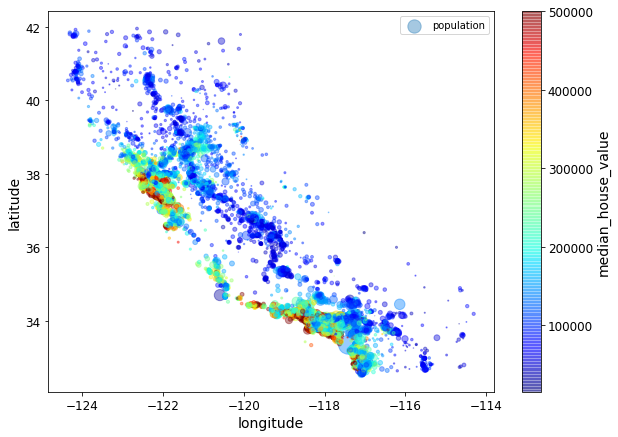

In [33]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

## Correlation Coefficients

Here we calculated the correlation coefficients using the `corr()` method, then plotted the most promising ones. I want to plot the ones Geron pointed out and also add `latitude` because it's interesting too.

In [34]:
corr_matrix = housing.corr()

In [35]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7738a973d0>,
      dtype=object)

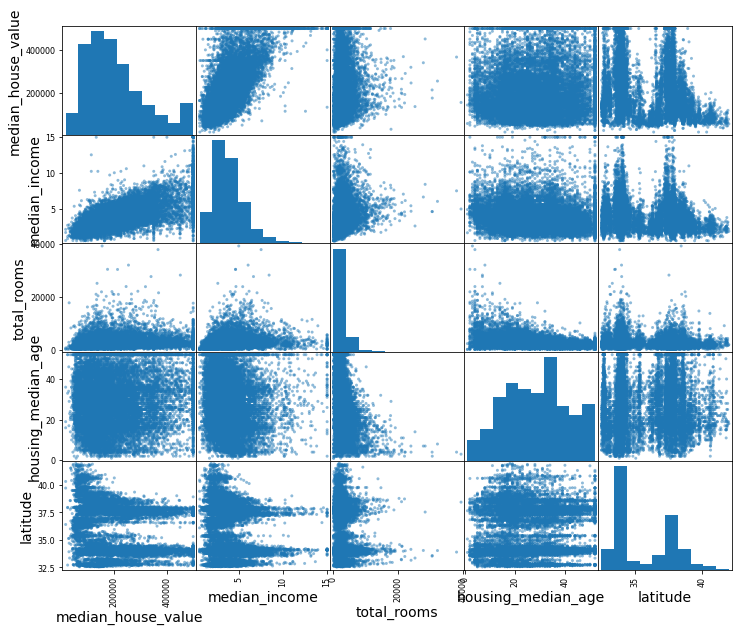

In [40]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age", "latitude"]
scatter_matrix(housing[attributes], figsize=(12, 10))

(0.0, 16.0, 0.0, 550000.0)

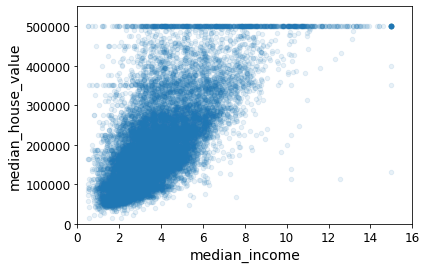

In [41]:
# zoom in on `median_income`

housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

Some attributes would do better in combination with each other to give us more information. Adding them here:

In [42]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [43]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

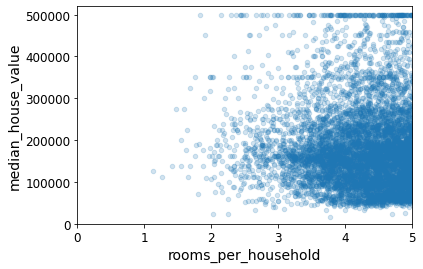

In [44]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

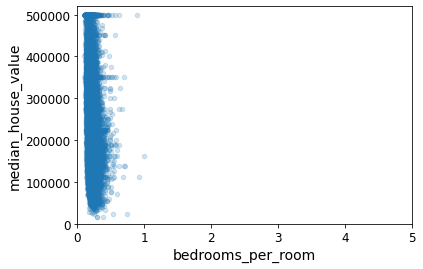

In [45]:
housing.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

I probably need to play with that last plot a little; I just added it with the same stats as the one above it to try and see the correlation. Since I can't really, but the book says it's there, I probably just need to change the alpha or something.

# Prepare Data for Machine Learning Algorithms